# Stock Price Prediction

##Part 1 - Data Preprocessing

###Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import yfinance as yf

###Downloading the data from yfinance package for LT stock in NSE exchange

In [2]:
data = yf.download("LT.NS", start="2016-01-01", end="2022-06-30")

[*********************100%***********************]  1 of 1 completed


###Preprocessing and storing the data

In [3]:
data.pop("Adj Close")
data[["Open", "High", "Low", "Close"]] = data[["Open", "High", "Low", "Close"]].round(2)
data["Volume"] = data["Volume"].astype(float)
data.to_csv("LT.csv")

###Importing the dataset from the saved file

In [4]:
df = pd.read_csv("LT.csv")
df.pop("Date")
df.head()

,Open,High,Low,Close,Volume
0,852.67,860.67,848.37,859.47,1127733.0
1,857.33,859.97,835.53,837.30,2767263.0
2,841.87,846.00,835.00,837.93,2470134.0
3,839.33,839.87,823.33,824.57,2728635.0
4,818.77,818.90,800.00,804.27,4689760.0


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,1604.0,1.265379e+03,2.903348e+02,697.20,9.959925e+02,1295.000,1423.15,2075.65
High,1604.0,1.279320e+03,2.932668e+02,735.00,1.005000e+03,1305.275,1434.85,2078.55
Low,1604.0,1.250286e+03,2.878728e+02,661.00,9.852050e+02,1280.700,1407.20,2042.00
Close,1604.0,1.263990e+03,2.903575e+02,702.43,9.949525e+02,1292.100,1422.50,2069.40
Volume,1604.0,3.028140e+06,2.123486e+06,255086.00,1.777782e+06,2382452.000,3603295.00,21153346.00


###Splitting into train set and test set

In [6]:
n = len(df)
train_df = df[0:int(n*0.9)]
test_df = df[int(n*0.1):]

###Standardization

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df_scaled = (train_df - train_mean) / train_std
test_df_scaled = (test_df - train_mean) / train_std

#convert to numpy values
train_set_scaled = train_df_scaled.values
test_set_scaled = test_df_scaled.values

###Forming training and testing data structures

In [8]:
IN_STEPS = 60
OUT_STEPS = 21
#1st output is equal to the last input. We will use this to modify the model's predictions to reduce gaps caused by extrapolation

In [9]:
def get_input_output_arr(scaled_np_arr, in_steps, out_steps):
    X = []
    Y = []

    for i in range(in_steps+out_steps-1, len(scaled_np_arr)):
        X.append(scaled_np_arr[i-(in_steps+out_steps-1):i-out_steps+1, :])
        Y.append(scaled_np_arr[i-out_steps:i,0])
    
    return np.array(X), np.array(Y)

In [10]:
X_train, Y_train = get_input_output_arr(train_set_scaled, IN_STEPS, OUT_STEPS)
X_test, Y_test = get_input_output_arr(test_set_scaled, IN_STEPS, OUT_STEPS)

##Part 2 - Building, training and evaluating the models

### Importing the Keras libraries and packages

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dropout

A custom metric - 'custom_accuracy'.
A prediction scores 1 (or is said to be correct) if the model successfully estimated whether the price would go up or down.

In [12]:
def custom_accuracy(y_true, y_pred):
    
    correct = 0
    
    #for the entire batch
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        start_true = y_t[0]
        end_true = y_t[-1]
        start_pred = y_p[0]
        end_pred = y_p[-1]
    
        if (((end_true >= start_true) and (end_pred >= start_pred)) or ((end_true <= start_true) and (end_pred <= start_pred))):
            correct += 1
    return correct/len(y_true)

Initializing a dictionary to store the performance of the models

In [13]:
performance = {}

###Baseline Model

A simple baseline is to repeat the input sequence. That is, whatever happened will repeat itself. That is, prices of the next x days = prices of the first x days in the output sequence.

In [14]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    outputs = inputs[:, :(OUT_STEPS), 0]
    return outputs

repeat_baseline = RepeatBaseline()

Metal device set to: Apple M1


2022-07-20 17:24:49.381935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-20 17:24:49.382030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


###Compiling and fitting to training set

In [15]:
def compile_and_fit(model, X_train, Y_train):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = [custom_accuracy])
    model.fit(X_train, Y_train, epochs=25, batch_size=32)

In [16]:
compile_and_fit(repeat_baseline, X_train, Y_train)

Epoch 1/25


2022-07-20 17:24:49.509216: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-20 17:24:49.673960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.4764 - custom_accuracy: 0.5457
Epoch 2/25
43/43 [==============================] - 1s 18ms/step - loss: 0.4764 - custom_accuracy: 0.5432
Epoch 3/25
43/43 [==============================] - 1s 19ms/step - loss: 0.4764 - custom_accuracy: 0.5462
Epoch 4/25
43/43 [==============================] - 1s 19ms/step - loss: 0.4764 - custom_accuracy: 0.5452
Epoch 5/25
43/43 [==============================] - 1s 19ms/step - loss: 0.4764 - custom_accuracy: 0.5452
Epoch 6/25
43/43 [==============================] - 1s 18ms/step - loss: 0.4764 - custom_accuracy: 0.5457
Epoch 7/25
43/43 [==============================] - 1s 33ms/step - loss: 0.4764 - custom_accuracy: 0.5427
Epoch 8/25
43/43 [==============================] - 1s 18ms/step - loss: 0.4764 - custom_accuracy: 0.5457
Epoch 9/25
43/43 [==============================] - 1s 18ms/step - loss: 0.4764 - custom_accuracy: 0.5417
Epoch 10/25
43/43 [==============================] - 1s 1

###Evaluation

In [17]:
performance['Baseline'] = repeat_baseline.evaluate(X_test, Y_test)

 4/43 [=>............................] - ETA: 0s - loss: 0.2785 - custom_accuracy: 0.5391

2022-07-20 17:25:11.825215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 0.5164 - custom_accuracy: 0.5496


###Simple ANN with 4 Dense layers stacked

In [18]:
ann_model = tf.keras.Sequential([
    Lambda(lambda x: x[:, -1, :]),
    Dense(units=50, activation='relu'),
    Dense(units=50, activation='relu'),
    Dense(units=50, activation='relu'),
    Dense(units=50, activation='relu'),
    Dense(units=21)
])

###Compiling and fitting to training set

In [19]:
compile_and_fit(ann_model, X_train, Y_train)

Epoch 1/25


2022-07-20 17:25:13.056957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.5117 - custom_accuracy: 0.5769
Epoch 2/25
43/43 [==============================] - 1s 21ms/step - loss: 0.0888 - custom_accuracy: 0.4844
Epoch 3/25
43/43 [==============================] - 1s 21ms/step - loss: 0.0701 - custom_accuracy: 0.5566
Epoch 4/25
43/43 [==============================] - 1s 20ms/step - loss: 0.0687 - custom_accuracy: 0.5507
Epoch 5/25
43/43 [==============================] - 1s 21ms/step - loss: 0.0692 - custom_accuracy: 0.5784
Epoch 6/25
43/43 [==============================] - 1s 21ms/step - loss: 0.0685 - custom_accuracy: 0.5617
Epoch 7/25
43/43 [==============================] - 1s 21ms/step - loss: 0.0680 - custom_accuracy: 0.5702
Epoch 8/25
43/43 [==============================] - 1s 22ms/step - loss: 0.0677 - custom_accuracy: 0.5762
Epoch 9/25
43/43 [==============================] - 1s 21ms/step - loss: 0.0680 - custom_accuracy: 0.5856
Epoch 10/25
43/43 [==============================] - 1s 2

###Evaluation

In [20]:
performance['ANN'] = ann_model.evaluate(X_test, Y_test)


 1/43 [..............................] - ETA: 10s - loss: 0.0114 - custom_accuracy: 0.7500

2022-07-20 17:25:39.166123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.0783 - custom_accuracy: 0.6314


### A neural network with 4 LSTM layers

In [21]:
lstm_model = tf.keras.Sequential([
    LSTM(units=50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.3),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.3),
    LSTM(units = 50),
    Dropout(0.3),
    Dense(units = OUT_STEPS)
])

###Compiling and fitting to training set

In [22]:
compile_and_fit(lstm_model, X_train, Y_train)

Epoch 1/25


2022-07-20 17:25:42.610838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:25:43.085015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:25:43.234380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:25:43.341030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:25:43.444072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:25:43.602186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:25:43.822035: I tensorflow/core/grappler/optimizers/cust

43/43 [==============================] - 9s 116ms/step - loss: 0.4110 - custom_accuracy: 0.5052
Epoch 2/25
43/43 [==============================] - 4s 101ms/step - loss: 0.1768 - custom_accuracy: 0.5307
Epoch 3/25
43/43 [==============================] - 4s 95ms/step - loss: 0.1374 - custom_accuracy: 0.5156
Epoch 4/25
43/43 [==============================] - 3s 82ms/step - loss: 0.1162 - custom_accuracy: 0.5190
Epoch 5/25
43/43 [==============================] - 4s 101ms/step - loss: 0.1050 - custom_accuracy: 0.5695
Epoch 6/25
43/43 [==============================] - 4s 100ms/step - loss: 0.0937 - custom_accuracy: 0.5869
Epoch 7/25
43/43 [==============================] - 4s 103ms/step - loss: 0.0859 - custom_accuracy: 0.5672
Epoch 8/25
43/43 [==============================] - 4s 104ms/step - loss: 0.0815 - custom_accuracy: 0.5959
Epoch 9/25
43/43 [==============================] - 5s 105ms/step - loss: 0.0717 - custom_accuracy: 0.6341
Epoch 10/25
43/43 [==============================]

###Evaluation

In [23]:
performance['LSTM'] = lstm_model.evaluate(X_test, Y_test)

2022-07-20 17:27:23.122036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:27:23.295110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:27:23.400823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:27:23.497081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 17:27:23.591132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 65ms/step - loss: 0.0480 - custom_accuracy: 0.7719


## Part 3- Comparing the performances through a plot

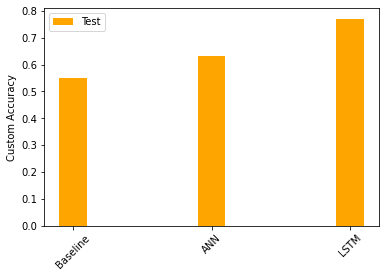

In [24]:
x = np.arange(len(performance))
width = 0.2

metric_name = 'custom_accuracy'
metric_index = lstm_model.metrics_names.index('custom_accuracy')
test_acc = [v[metric_index] for v in performance.values()]

plt.bar(x, test_acc, width, label='Test', color="orange")
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'Custom Accuracy')
_ = plt.legend()

In [25]:
print(performance)

{'Baseline': [0.5163539052009583, 0.5495639443397522], 'ANN': [0.07832185924053192, 0.6313953399658203], 'LSTM': [0.04796585068106651, 0.7719476222991943]}


In [26]:
print(metric_index)

1
